# Road Accident Risk — Notebook

This notebook explores the road accident dataset, performs EDA, preprocessing, compares several regression models (RandomForest, XGBoost, LightGBM), and prepares a submission file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Load datasets

Read the training and test CSV files into pandas DataFrames (`train`, `test`). Verify basic structure with `.head()` and `.shape`.

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head(10)


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56
5,5,highway,3,0.54,70,night,foggy,True,False,morning,False,True,0,0.61
6,6,highway,1,0.04,45,night,foggy,False,True,morning,True,False,2,0.20
7,7,highway,2,0.33,45,daylight,clear,False,True,evening,False,True,0,0.16
8,8,rural,3,0.63,25,dim,clear,True,False,evening,True,True,2,0.18
9,9,urban,4,0.38,45,dim,clear,True,True,afternoon,True,True,2,0.15


In [4]:
train.shape


(517754, 14)

In [5]:
train.columns


Index(['id', 'road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting',
       'weather', 'road_signs_present', 'public_road', 'time_of_day',
       'holiday', 'school_season', 'num_reported_accidents', 'accident_risk'],
      dtype='object')

In [6]:
train.isnull().sum()

id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64

## Exploratory Data Analysis (EDA)

Visualize relationships between numeric/categorical features and the target `accident_risk`. Use scatterplots, boxplots and a correlation heatmap to identify patterns.

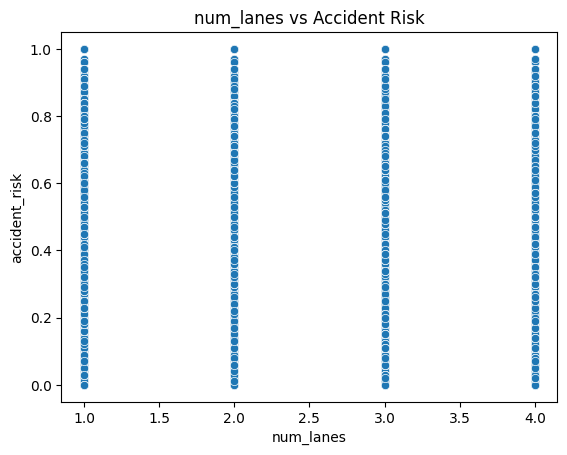

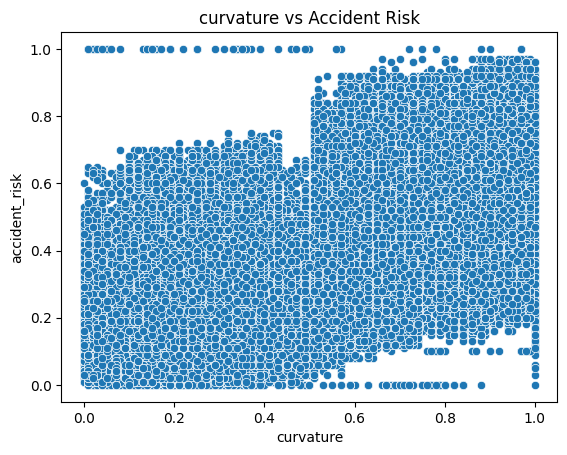

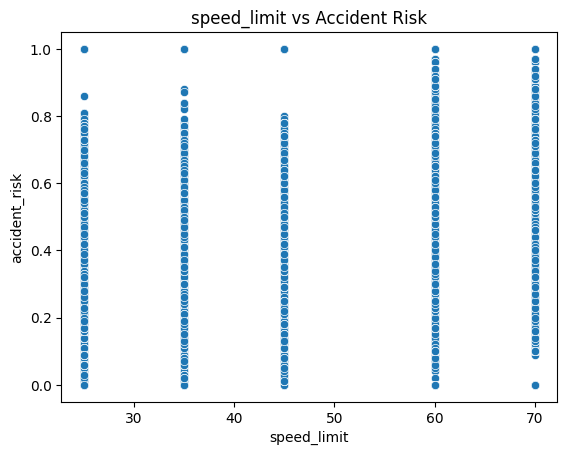

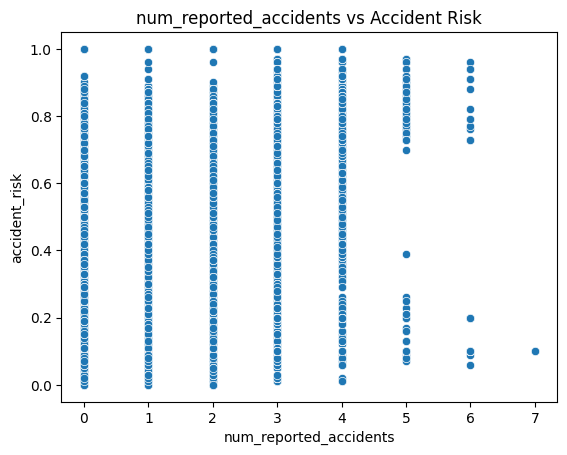

In [7]:
num_cols = ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']
for col in num_cols:
    sns.scatterplot(x=train[col], y=train['accident_risk'])
    plt.title(f"{col} vs Accident Risk")
    plt.show()


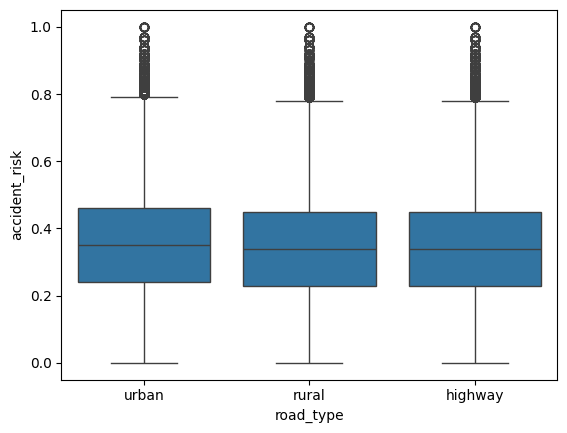

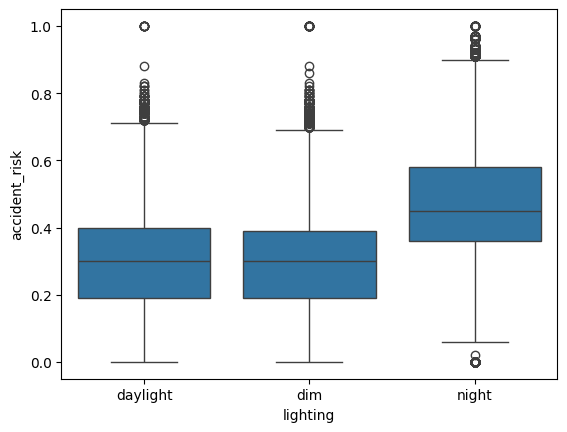

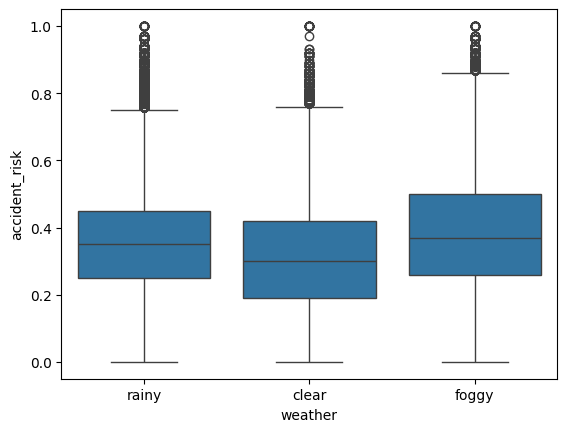

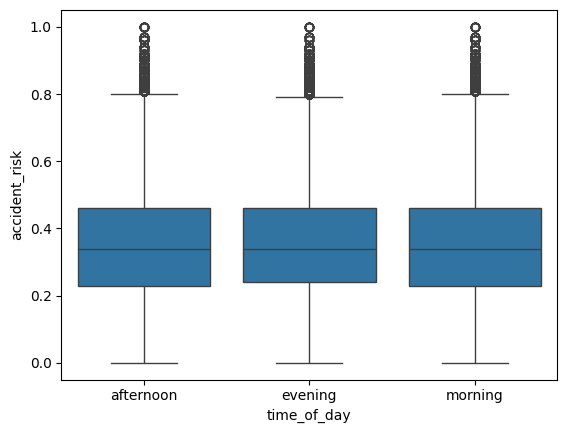

In [8]:
cat_cols = ['road_type', 'lighting', 'weather', 'time_of_day']
for col in cat_cols:
    sns.boxplot(x=col, y='accident_risk', data=train)
    plt.show()


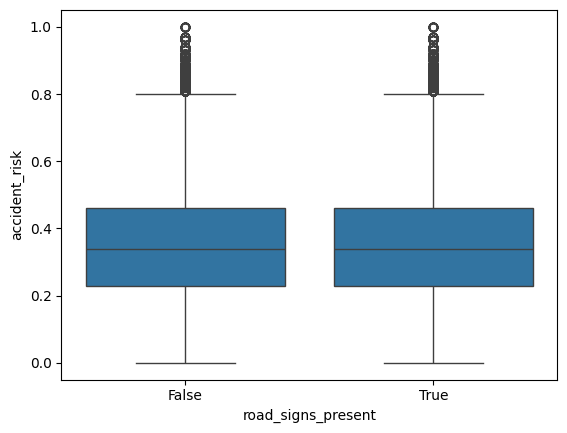

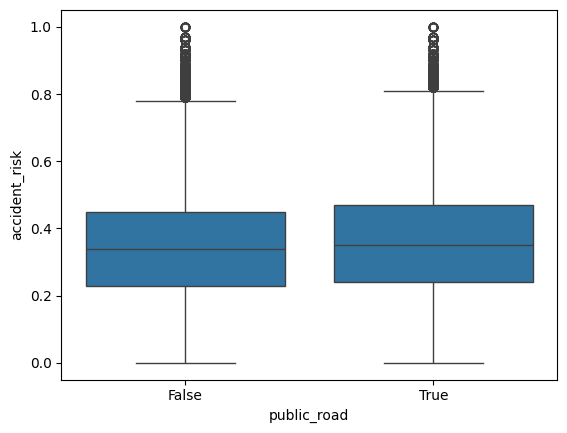

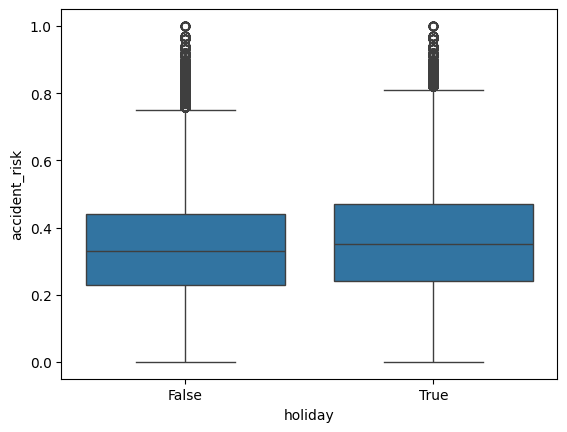

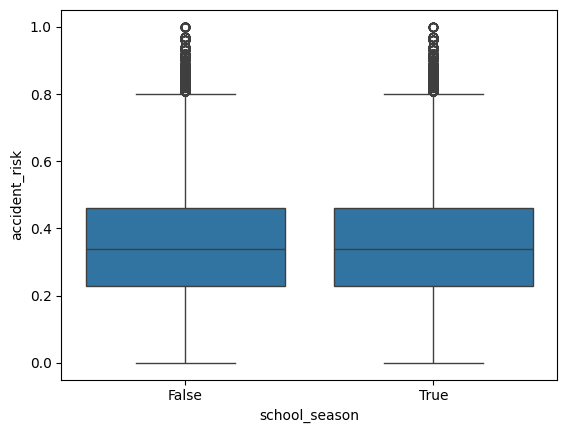

In [9]:
bool_cols = ['road_signs_present', 'public_road', 'holiday', 'school_season']
for col in bool_cols:
    sns.boxplot(x=col, y='accident_risk', data=train)
    plt.show()


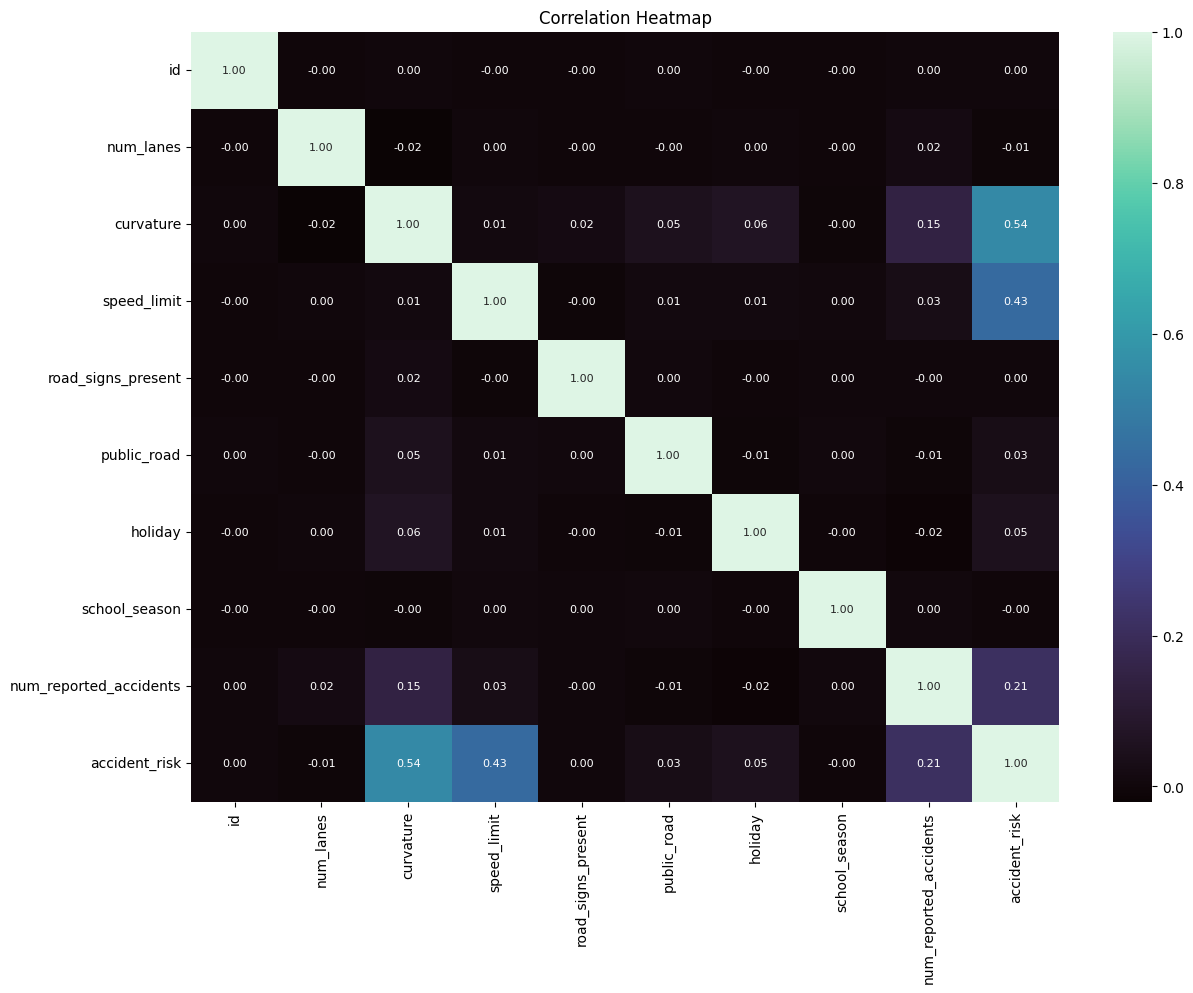

In [10]:
# Convert boolean columns to integers
bool_cols = ['road_signs_present', 'public_road', 'holiday', 'school_season']
for col in bool_cols:
    train[col] = train[col].astype(int)
    test[col] = test[col].astype(int)

# Compute correlation for numeric columns and plot
corr = train.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, cmap='mako', fmt='.2f', annot_kws={"size":8})
plt.title("Correlation Heatmap")
plt.show()


## Preprocessing

Convert boolean columns to integers, check correlations, and drop or transform columns as needed before encoding and scaling.

In [11]:
if 'id' in train.columns:
    train.drop(columns=['id'], inplace=True)
    print('id is dropped in train ....')
else:
    print('id NOT found in train')

if 'id' in test.columns:
    test.drop(columns=['id'], inplace=True)
    print('id is dropped in test ....')
else:
    print('id NOT found in test')


id is dropped in train ....
id is dropped in test ....


## Drop ID & Encode Categorical Features

Drop identifier columns if present, then encode categorical variables (label encoding) so models can consume them.

In [12]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ['road_type', 'lighting', 'weather', 'time_of_day']

for col in cat_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

train.head(10)


,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,2,2,0.06,35,0,2,0,1,0,0,1,1,0.13
1,2,4,0.99,35,0,0,1,0,1,1,1,0,0.35
2,1,4,0.63,70,1,0,0,1,2,1,0,2,0.30
3,0,4,0.07,35,1,2,1,1,2,0,0,1,0.21
4,1,1,0.58,60,0,1,0,0,1,1,0,1,0.56
5,0,3,0.54,70,2,1,1,0,2,0,1,0,0.61
6,0,1,0.04,45,2,1,0,1,2,1,0,2,0.20
7,0,2,0.33,45,0,0,0,1,1,0,1,0,0.16
8,1,3,0.63,25,1,0,1,0,1,1,1,2,0.18
9,2,4,0.38,45,1,0,1,1,0,1,1,2,0.15


In [13]:
# Scale numeric columns: fit on train, apply to test
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
num_cols = ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']
train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])
train.head(10)


,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,2,-0.438680,-1.572918,-0.703840,0,2,0,1,0,0,1,-0.209797,0.13
1,2,1.346344,1.839137,-0.703840,0,0,1,0,1,1,1,-1.325918,0.35
2,1,1.346344,0.518342,1.512963,1,0,0,1,2,1,0,0.906324,0.30
3,0,1.346344,-1.536229,-0.703840,1,2,1,1,2,0,0,-0.209797,0.21
4,1,-1.331192,0.334898,0.879591,0,1,0,0,1,1,0,-0.209797,0.56
5,0,0.453832,0.188143,1.512963,2,1,1,0,2,0,1,-1.325918,0.61
6,0,-1.331192,-1.646295,-0.070467,2,1,0,1,2,1,0,0.906324,0.20
7,0,-0.438680,-0.582321,-0.070467,0,0,0,1,1,0,1,-1.325918,0.16
8,1,0.453832,0.518342,-1.337212,1,0,1,0,1,1,1,0.906324,0.18
9,2,1.346344,-0.398877,-0.070467,1,0,1,1,0,1,1,0.906324,0.15


## Feature scaling

Standardize numeric features (`num_lanes`, `curvature`, `speed_limit`, `num_reported_accidents`) using `StandardScaler` to improve model convergence and comparability.

In [14]:
from sklearn.model_selection import train_test_split

X = train.drop(columns=['accident_risk'])
y = train['accident_risk']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)


In [15]:
X_train.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
143159,1,-0.438680,-0.215433,0.879591,1,0,0,0,0,1,1,0.906324
20172,0,1.346344,-1.132653,-1.337212,2,0,0,0,0,1,0,-0.209797
57926,2,-1.331192,-1.059275,1.512963,2,0,0,1,2,1,1,-0.209797
193319,2,0.453832,1.178740,0.879591,0,1,1,0,1,1,1,-0.209797
213938,1,0.453832,-0.215433,-0.703840,2,2,0,1,2,1,1,0.906324


In [16]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score


## Model imports & setup

Import model libraries (`RandomForest`, `xgboost`, `lightgbm`) and evaluation metrics used later (`MSE`, `R2`).

In [17]:
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
}


## Model definitions

Define model instances for comparison: `RandomForestRegressor`, `XGBRegressor`, and `LGBMRegressor` with baseline hyperparameters.

In [18]:
results = []

for name, model in models.items():
    print(f'Training {name}...')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({'Model': name, 'MSE': mse, 'R2': r2})


Training Random Forest...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 12
[LightGBM] [Info] Start training from score 0.352605


## Training loop

Train each model on `X_train`/`y_train`, predict on validation set, and record evaluation metrics (MSE, R2).

In [19]:
comparison_df = pd.DataFrame(results)
print(comparison_df.sort_values(by='MSE'))


           Model       MSE        R2
1        XGBoost  0.003169  0.885246
2       LightGBM  0.003176  0.884984
0  Random Forest  0.003544  0.871641


## Compare results & visualize

Create a `comparison_df` of metrics and visualize model performance (barplots for R2). Choose the best model for full training.

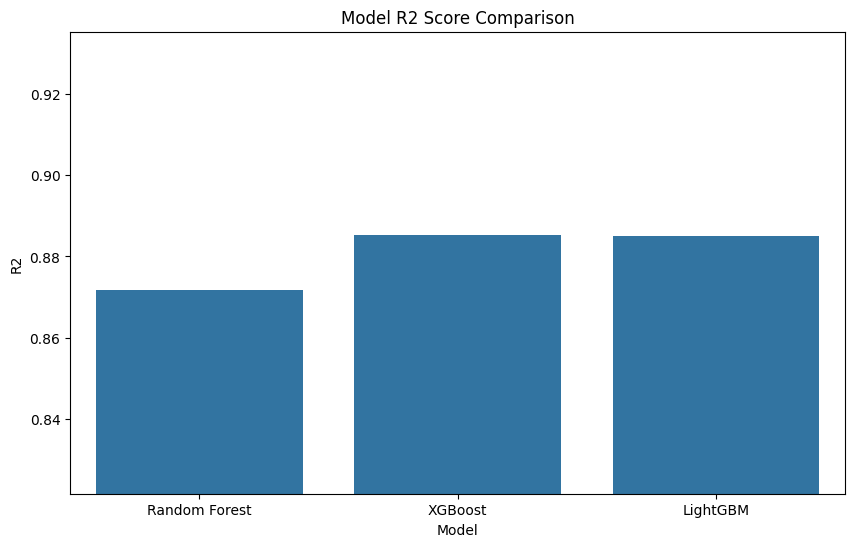

In [20]:
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='R2', data=comparison_df)
plt.title('Model R2 Score Comparison')
plt.ylim(
    comparison_df['R2'].min() - 0.05,
    comparison_df['R2'].max() + 0.05
)
plt.show()


In [21]:

xgb_full = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=300, learning_rate=0.05, random_state=42, n_jobs=-1)

if 'accident_risk' in train.columns:
    X_full = train.drop(columns=['accident_risk'])
    y_full = train['accident_risk']
else:
    raise ValueError('Target column "accident_risk" not found in train')


## Full training and prediction

Retrain the chosen model (XGBoost here) on the full training data and predict on the test set to generate final predictions for submission.

In [22]:
xgb_full.fit(X_full, y_full)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [23]:
y_test_pred = xgb_full.predict(test)


In [24]:
try:
    test_orig = pd.read_csv('test.csv')
    if 'id' in test_orig.columns:
        submission = pd.DataFrame({'id': test_orig['id'], 'accident_risk': y_test_pred})
    else:
        submission = pd.DataFrame({'accident_risk': y_test_pred})
except Exception:
    submission = pd.DataFrame({'accident_risk': y_test_pred})


## Prepare submission

Assemble predictions and `id` (if available) into a DataFrame and save as `submission_xgb.csv` for submission to the competition.

In [25]:
submission.to_csv('submission_xgb.csv', index=False)
print('Saved submission_xgb.csv')


Saved submission_xgb.csv
